<div style="width: 100%; clear: both;">
  <div style="float: left; width: 50%;">
    <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
  </div>
  <div style="float: right; width: 50%;">
    <p style="padding-top: 42px; text-align:right;">&nbsp;</p>
    <p style="padding-top: 42px; text-align:right;">M2.882 - TFM - Area 5 aula 1</p>
    <p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
  </div>
   <div style="width:100%; clear: both;">&nbsp;</div>
</div>

# PEC3 - Design & implementation

## Sale of access IoT devices in underground forums

Autor: [Sergio Fernández García](mailto:serfer2@protonmail.com)

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    RocCurveDisplay,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

### Data source

Given all threads from *Hack Forums* `Market` section, each document is a mix of data: Thread heading + First post content and timestamp.

All threads from sub-forums in Market section have been pre-processed. We've built two datasets by filtering all DDoS related threads:

- `ddos_full_dataset.csv`: (>40K docs) Full dataset with all market section documents related with DDoS.
- `ddos_groundtruth_dataset.csv`: (4K docs) Data sample, randomly extracted from full dataset. Every doc category has been annotated by differenciating beteen `supply` and `demand`. This dataset is intended for training and testing text classification models.

**NOTE:**

All contents have been cleaned when building the datasets. So we've clean words, ready to work with it.

Cleaning operations have been:

- Lower case all text.
- Removed: punctuation, accents, non-textual content like citing, images, urls, ... 

In [10]:
# Load both datasets

gtruth_df = pd.read_csv('datasets/ddos_ground_truth_dataset.csv')

gtruth_df.info()
gtruth_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         4071 non-null   object
 1   tstamp          4071 non-null   object
 2   matching_terms  4071 non-null   object
 3   category        4071 non-null   object
dtypes: object(4)
memory usage: 127.3+ KB


,content,tstamp,matching_terms,category
0,selling botnet zombies i'm selling a botnet 15...,2008-05-03 12:51:00+00:00,['botnet'],supply
1,i want to buy a botnet i am paying 0 20$ for e...,2009-04-16 02:19:00+00:00,['botnet'],demand
2,i want to buy a botnet i want to buy a botnet ...,2009-04-18 01:48:00+00:00,['botnet'],demand
3,selling fud copies of bandook rat 6 months upd...,2009-05-27 09:35:00+00:00,['ddos'],supply
4,selling up to 300 bots $0 50 each hello i am s...,2009-05-30 05:07:00+00:00,['botnet'],supply


In [11]:
# Categories as numeric values

categories = {v: i for i, v in enumerate(set(gtruth_df['category'].values))}
print(f'{categories}')
labels = [l for l in categories.values()]
target_names = [n for n in categories.keys()]

gtruth_df['target'] = [categories[c] for c in gtruth_df['category']]
gtruth_df.head()

{'demand': 0, 'supply': 1}


,content,tstamp,matching_terms,category,target
0,selling botnet zombies i'm selling a botnet 15...,2008-05-03 12:51:00+00:00,['botnet'],supply,1
1,i want to buy a botnet i am paying 0 20$ for e...,2009-04-16 02:19:00+00:00,['botnet'],demand,0
2,i want to buy a botnet i want to buy a botnet ...,2009-04-18 01:48:00+00:00,['botnet'],demand,0
3,selling fud copies of bandook rat 6 months upd...,2009-05-27 09:35:00+00:00,['ddos'],supply,1
4,selling up to 300 bots $0 50 each hello i am s...,2009-05-30 05:07:00+00:00,['botnet'],supply,1


In [12]:
# Split ground truth dataset for training and test (80/20 ratio)
gtruth_training_df = gtruth_df.sample(frac=0.8)
gtruth_testing_df = gtruth_df.drop(gtruth_training_df.index)

print(f'{gtruth_training_df.shape}')
print(f'{gtruth_testing_df.shape}')

(3257, 5)
(814, 5)


### Data pre-process

Since there are a lot of different words in corpus, we've a high dimensional dataset (too much different features).

Building feature vectors with full word list is inefficient and can be unmanageable. This is why we're going to maintain in memory only non-zero parts of feature vectors.

#### Tokenization:

Before building feature vectors, tokenization is needed. It basically consists in breaking down text in term vectors and filtering *stop words*.

In [13]:
X_train_counts = CountVectorizer().fit_transform(gtruth_training_df['content'])
print(f'{X_train_counts.shape}')

(3257, 12537)


#### Term Frequency

Some thread contents are longer than others, it can result in a higher average count values than shorter ones, but they really talk about same topic (category).

Among that, some words appears in many documents in the corpus. These *common* words are less informative, so we'll downscale weights for these words.

In order to avoid this problem, we calculate *tf* and *tf-idf* (Term Frequency times Inverse Document Frequency). Both (*tf* and *tf-idf*) are computed by `TfidfTransformer`.

In [14]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(f'{X_train_tfidf.shape}')

(3257, 12537)


### Model training

We're going to test classification performance for four well-known models. These models are widely used in classification tasks:

- LinearSVC: Linear Support Vector Classification.
- SGD: Stochastic Gradient Descent.
- K nearest Neighbor.
- Multinomial Naive Bayes.

Performance metrics to be analyzed are *precision*, *recall*, *F1-score* and occurrences of each class (*support*).

Confusion matrix will show us ratio of correct and wrong classification between categories (only two categories in our case).


In [15]:
def evaluate_model(model_name, x_test, y_test, classifier, labels, target_names):
    # Prediction with test dataset
    predicted = classifier.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_true=gtruth_testing_df['target'], y_pred=predicted)
    print(f'{model_name} accuracy: {accuracy:.02f}')

    # Metrics
    metrics = classification_report(
        y_true=y_test,
        y_pred=predicted,
        labels=labels,
        target_names=target_names,
        output_dict=True,
    )

    # Confusion matrix
    cfm = pd.crosstab(
        y_test,
        predicted,
        rownames=['Category'],
        colnames=['Pred. category'],
    )

    return predicted, metrics, cfm


def plot_confusion_matrix(cfm, title):
    ax = plt.axes()
    sn.heatmap(cfm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(f'{title} - Confusion Matrix')
    plt.show()

#### LinearSVC

LinearSVC accuracy: 0.96


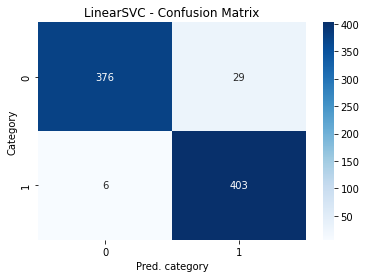

In [16]:
linear_svc_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', LinearSVC(random_state=0, tol=1e-05)),
    ]
)

# Training
linear_svc_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation
linear_svc_predicted, _linear_svc_metrics, linear_svc_cfm = evaluate_model(
    model_name='LinearSVC',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=linear_svc_text_classifier,
    labels=labels,
    target_names=target_names,
)
linear_svc_metrics = _linear_svc_metrics.get('macro avg')
linear_svc_metrics['accuracy'] = _linear_svc_metrics.get('accuracy')

plot_confusion_matrix(cfm=linear_svc_cfm, title='LinearSVC')

#### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) accuracy: 0.93


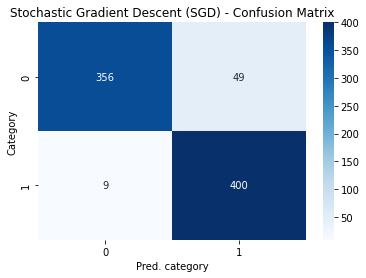

In [17]:
sgd_model = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-3,
    random_state=42,
    max_iter=5,
    tol=None,
)
sgd_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', sgd_model),
    ]
)

# Training
sgd_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation
sgd_predicted, _sgd_metrics, sgd_cfm = evaluate_model(
    model_name='Stochastic Gradient Descent (SGD)',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=sgd_text_classifier,
    labels=labels,
    target_names=target_names,
)
sgd_metrics = _sgd_metrics.get('macro avg')
sgd_metrics['accuracy'] = _sgd_metrics.get('accuracy')

plot_confusion_matrix(cfm=sgd_cfm, title='Stochastic Gradient Descent (SGD)')

#### K-nearest neighbors

K-nearest neighbors accuracy: 0.79


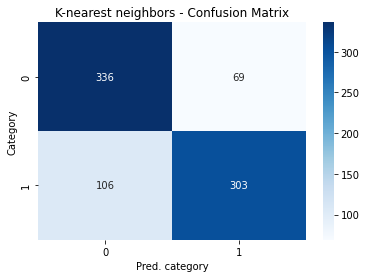

In [18]:
knn_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', KNeighborsClassifier(n_neighbors=12)),
    ]
)

# Training
knn_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation
knn_predicted, _knn_metrics, knn_cfm = evaluate_model(
    model_name='K-nearest neighbors',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=knn_text_classifier,
    labels=labels,
    target_names=target_names,
)
knn_metrics = _knn_metrics.get('macro avg')
knn_metrics['accuracy'] = _knn_metrics.get('accuracy')

plot_confusion_matrix(cfm=knn_cfm, title='K-nearest neighbors')

#### Multinomial Naïve Bayes

Multinomial Naïve Bayes accuracy: 0.89


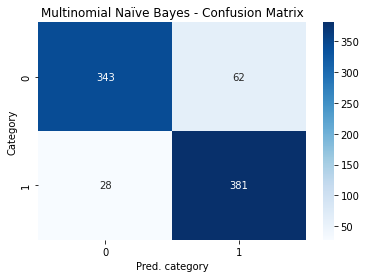

In [19]:
mnb_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB()),
    ]
)

# Training
mnb_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation
mnb_predicted, _mnb_metrics, mnb_cfm = evaluate_model(
    model_name='Multinomial Naïve Bayes',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=mnb_text_classifier,
    labels=labels,
    target_names=target_names,
)
mnb_metrics = _mnb_metrics.get('macro avg')
mnb_metrics['accuracy'] = _mnb_metrics.get('accuracy')

plot_confusion_matrix(cfm=mnb_cfm, title='Multinomial Naïve Bayes')

### Model evaluation

In [20]:
models_report = {}
models_report = pd.DataFrame({
    'model': ['Linear Support Vector Classification.', 'Stochastic Gradient Descent', 'K-nearest Neighbor', 'Multinomial Naïve Bayes'],
    'accuracy': [linear_svc_metrics['accuracy'], sgd_metrics['accuracy'], knn_metrics['accuracy'], mnb_metrics['accuracy'],],
    'precision': [linear_svc_metrics['precision'], sgd_metrics['precision'], knn_metrics['precision'], mnb_metrics['precision'],],
    'recall': [linear_svc_metrics['recall'], sgd_metrics['recall'], knn_metrics['recall'], mnb_metrics['recall'],],
    'F1 score': [linear_svc_metrics['f1-score'], sgd_metrics['f1-score'], knn_metrics['f1-score'], mnb_metrics['f1-score'],],
}).sort_values(
    by='accuracy',
    ascending=False
)

#### Metrics

In [21]:
models_report

,model,accuracy,precision,recall,F1 score
0,Linear Support Vector Classification.,0.957002,0.958582,0.956863,0.956955
1,Stochastic Gradient Descent,0.928747,0.933106,0.928504,0.928538
3,Multinomial Naïve Bayes,0.889435,0.892287,0.889227,0.889193
2,K-nearest Neighbor,0.785012,0.787349,0.785230,0.784658


#### ROC curve

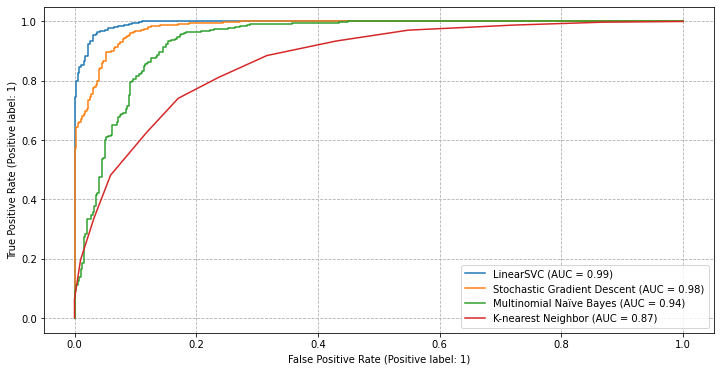

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
RocCurveDisplay.from_estimator(linear_svc_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='LinearSVC')
RocCurveDisplay.from_estimator(sgd_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='Stochastic Gradient Descent')
RocCurveDisplay.from_estimator(mnb_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='Multinomial Naïve Bayes')
RocCurveDisplay.from_estimator(knn_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='K-nearest Neighbor')
ax.grid(linestyle="--")
plt.show()

### Data Analysis

Once we've selected a model, it's time to analyse full dataset.

First, we need to load full dataset and label docs according to model predictions.

In [26]:
# Load full dataset
full_df = pd.read_csv('datasets/ddos_full_dataset.csv')
full_df.head()

# Label documents
categories_by_value = {v: k for k, v in categories.items()}  # {'demand': 0, 'supply': 1} -> {0: 'demand', 1: 'supply'}
labeled_full_df = full_df.copy()
labeled_full_df['category'] = linear_svc_text_classifier.predict(full_df['content'])
labeled_full_df['category_name'] = [categories_by_value[value] for value in labeled_full_df['category']]
labeled_full_df.head()

,content,tstamp,matching_terms,category,category_name
0,buying botnet im buying a good botnet with alo...,2008-02-18 08:37:00+00:00,['botnet'],0,demand
1,botnet with undetected server 4sale hey people...,2008-03-21 08:47:00+00:00,['botnet'],1,supply
2,interested in purchasing a botnet im intereste...,2008-04-09 04:41:00+00:00,"['botnet', 'ddos']",0,demand
3,trojans botnet source keyloggers packers crypt...,2008-04-15 07:57:00+00:00,['botnet'],1,supply
4,professional bulletproof hosting service from ...,2008-04-24 12:11:00+00:00,['botnet'],1,supply


#### Labels evolution over time

Our purpose is to analyse supply and demand evolution over time. 

Then we'll extract relevant information as frequent tech terms, contact methods, preferred payment methods, prices and so on.